In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym
import seaborn as sn

import pycollocation

Consider the following boundary value problem:
\begin{align}
    \frac{d T_1}{d_A} =& -q,\ T_1(0) = T_{1,0} \\
    \frac{d T_2}{d_A} =& -\frac{1}{2}q,\ T_2(A_{hx}) = T_{2,A_{hx}} \\
\end{align}
where $q = (T_1 - T_2)U$.

This boundary value problem describes a counter current heat exchanger; a hot liquid enters a device and exchanges heat across a metal plate with a cold liquid traveling through the device in the opposite direction. Here, $T_1$ is the temperature of the hot stream, $T_2$ is the temperature of the cold stream, $q$ is the rate of heat transfer from the hot fluid to the cold fluid, $U$ is the overall heat transfer coefficient and $A_hx$ is the total area of the heat exchanger.

In [4]:
# provide numerical values for the parameters
params = {'T10': 130, 'T2Ahx': 70, 'U': 1.0}

def q(T1, T2, U):
    return (T1 - T2) * U

def rhs(A, T1, T2, U, **params):
    return [-q(T1, T2, U), -0.5 * q(T1, T2, U)]

def bcs_lower(A, T1, T2, T10, **params):
    return [T1 - T10]

def bcs_upper(A, T1, T2, T2Ahx, **params):
    return [T2 - T2Ahx]

In [5]:
problem = pycollocation.problems.TwoPointBVP(bcs_lower, bcs_upper, 1, 2, params, rhs)

In [8]:
def initial_mesh(domain, num, problem):
    As = np.linspace(domain[0], domain[1], num)
    T1s = np.repeat(0.5 * (problem.params['T10'] + problem.params['T2Ahx']), num)
    return As, T1s, T1s


In [10]:
polynomial_basis = pycollocation.basis_functions.PolynomialBasis()
solver = pycollocation.solvers.Solver(polynomial_basis)

basis_kwargs = {'kind': 'Chebyshev', 'domain': [0, 5.0], 'degree': 15}

As, T1s, T2s = initial_mesh(basis_kwargs['domain'], 1000, problem)
T1_poly = polynomial_basis.fit(As, T1s, **basis_kwargs)
T2_poly = polynomial_basis.fit(As, T2s, **basis_kwargs)
initial_coefs = np.hstack([T1_poly.coef, T2_poly.coef])

solution = solver.solve(basis_kwargs, initial_coefs, problem)


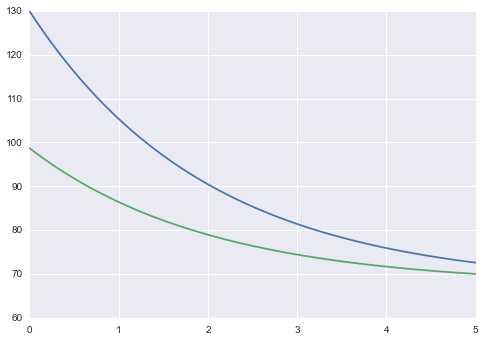

In [11]:
T1_soln, T2_soln = solution.evaluate_solution(As)
plt.plot(As, T1_soln)
plt.plot(As, T2_soln)
plt.show()

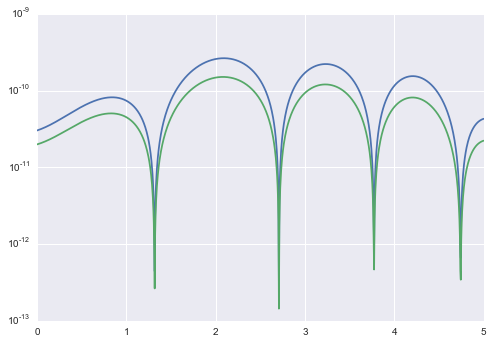

In [12]:
T1_normalized_resids, T2_normalized_resids = solution.normalize_residuals(As)
plt.plot(As, np.abs(T1_normalized_resids))
plt.plot(As, np.abs(T2_normalized_resids))
plt.yscale('log')
plt.show()